In [1]:
import pickle
import re
import base64
import pandas as pd
import wikipedia as wiki
from multiprocessing import Pool

import warnings

from PIL import Image
import requests
from io import BytesIO

from IPython.display import HTML

In [2]:
pickle_in = open("../data/raw_df.pkl","rb")
df = pickle.load(pickle_in)

In [5]:
def filter_df(df):
    return df

def get_url(x):
    return x[0] if len(x)==2 else x

def get_id(x):
    return x[0][-9:] if len(x)==2 else x[-9:]

def get_name(x):
    # TODO: improve it and get a list of name instead
    if isinstance(x, str):
        return None
    
    return ' '.join(re.findall('([\S]* [\S]*|[\S]*|[\S]*\, [\S]*[ \S*]+) \([\d]{2}', x[0]))


def get_wiki_name(x):
    # TODO: improve it by requesting to BNT database
    return x


def get_wiki_info(x):  
    empty_return = {
            'wiki_url': None, 
            'wiki_n_langs': 0, # TODO: Wikipedia-API has this feature
            'wiki_n_categories': None, 
            'wiki_n_links': None,
            'wiki_n_images': None,
            'wiki_n_references': None,
            'wiki_n_content': None
    }
    if x is None:
        return empty_return
    
    try:
        s = wiki.page(x)
        return {
            'wiki_url': s.url, 
            'wiki_n_langs': 0,
            'wiki_n_categories': len(s.categories), 
            'wiki_n_links': len(s.links),
            'wiki_n_images': len(s.images),
            'wiki_n_references': len(s.references),
            'wiki_n_content': len(s.content)
        }
    
    except:
        return empty_return
    

def get_gallica_image(url):
    # TODO: get better image and crop it
    try:
        image_url = url + '/f1.lowres'
        response = requests.get(image_url, stream=True)
        img = Image.open(BytesIO(response.content))
        img.thumbnail((150, 150), Image.LANCZOS)
        return img
    except:
        pass


def get_data(gallica_output):
    result = pd.DataFrame()
    
    filtered = filter_df(gallica_output)
    
    result['id'] = filtered['dc:identifier'].apply(get_id)
    result['gallica_url'] = filtered['dc:identifier'].apply(get_url)
    result['date'] = filtered['dc:date']
    result['name'] = filtered['dc:subject'].apply(get_name)
    result['wiki_name'] = result['name'].apply(get_wiki_name)
    
    p = Pool(8)
    wiki_info = pd.DataFrame(p.map(get_wiki_info, result['wiki_name'].values))
    p.close()
    p.join()
    
    result[['wiki_url', 
            'wiki_n_langs',
            'wiki_n_categories', 
            'wiki_n_links', 
            'wiki_n_images', 
            'wiki_n_references',
            'wiki_n_content']] = wiki_info
    
    p = Pool(8)
    images = p.map(get_gallica_image, result['gallica_url'].values)
    p.close()
    p.join()
    
    result['image'] = pd.Series(images)
    
    return list(result.T.to_dict().values())


def populate_db(data):
    return data

In [6]:
r = get_data(df[0:20])

,id,gallica_url,date,name,wiki_name,wiki_url,wiki_n_langs,wiki_n_categories,wiki_n_links,wiki_n_images,wiki_n_references,wiki_n_content,image
0,53163492h,https://gallica.bnf.fr/ark:/12148/btv1b53163492h,1875-1895,None,None,None,0,NaN,NaN,NaN,NaN,NaN,
1,531634912,https://gallica.bnf.fr/ark:/12148/btv1b531634912,1875-1895,None,None,None,0,NaN,NaN,NaN,NaN,NaN,
2,531638493,https://gallica.bnf.fr/ark:/12148/btv1b531638493,1875-1895,None,None,None,0,NaN,NaN,NaN,NaN,NaN,
3,53164917p,https://gallica.bnf.fr/ark:/12148/btv1b53164917p,1875-1895,None,None,None,0,NaN,NaN,NaN,NaN,NaN,
4,531688758,https://gallica.bnf.fr/ark:/12148/btv1b531688758,1875-1895,None,None,None,0,NaN,NaN,NaN,NaN,NaN,
5,53168876q,https://gallica.bnf.fr/ark:/12148/btv1b53168876q,1875-1895,None,None,None,0,NaN,NaN,NaN,NaN,NaN,
6,531651477,https://gallica.bnf.fr/ark:/12148/btv1b531651477,1875-1895,None,None,None,0,NaN,NaN,NaN,NaN,NaN,
7,53168872x,https://gallica.bnf.fr/ark:/12148/btv1b53168872x,1875-1895,"Auguez, Mathilde","Auguez, Mathilde",https://en.wikipedia.org/wiki/Mathilde_Auguez,0,13.0,30.0,6.0,15.0,2180.0,
8,531688701,https://gallica.bnf.fr/ark:/12148/btv1b531688701,1875-1895,"Auguez, Mathilde","Auguez, Mathilde",https://en.wikipedia.org/wiki/Mathilde_Auguez,0,13.0,30.0,6.0,15.0,2180.0,
9,53171770j,https://gallica.bnf.fr/ark:/12148/btv1b53171770j,1875-1895,"Bruant, Aristide","Bruant, Aristide",https://en.wikipedia.org/wiki/Aristide_Bruant,0,26.0,66.0,3.0,18.0,3123.0,

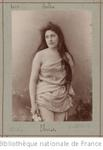
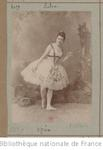
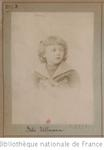
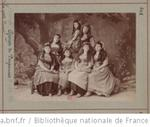
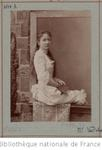
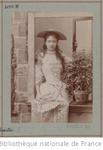
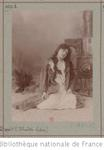
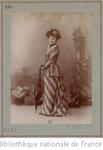
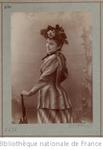
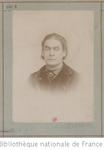
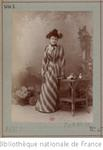
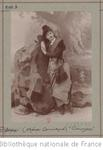
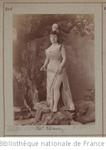
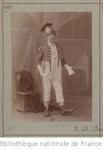
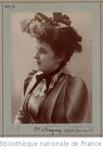
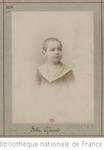
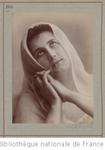
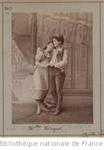
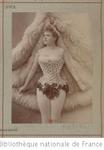
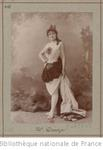

In [7]:
def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

HTML(pd.DataFrame(r).to_html(formatters={'image': image_formatter}, escape=False))